## Introducción e hipótesis

El objetivo es predecir si un cliente se dará de baja o no de la plataforma.

In [2]:
#Las librerías utilizadas en este documento son:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn import metrics
from matplotlib.ticker import ScalarFormatter
from matplotlib import gridspec
sns.set()

## Carga de datos

In [3]:
data  = pd.read_csv('./data/Datos ML 2021 Q2.csv', sep=';')
print("El dataset tiene {} filas y {} columnas".format(data.shape[0], data.shape[1]))
data.head()

El dataset tiene 5099 filas y 20 columnas


,CustomerID,Churn,CustomerTenure,MainDeviceLogin,CityTier,WarehouseToHome,MainPaymentMode,Gender,HourSpendOnApp,DeviceRegistered,PrefCategory,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,Somewhat satified,Single,9,1,11.0,1.0,1.0,5.0,160
1,50002,1,NaN,Tablet,1,8.0,UPI,Male,3.0,4,Mobile,Satisfied,Single,7,1,15.0,0.0,1.0,0.0,121
2,50003,1,NaN,Tablet,1,30.0,Debit Card,Male,2.0,4,Mobile,Satisfied,Single,6,1,14.0,0.0,1.0,3.0,120
3,50004,1,0.0,Tablet,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,Excelent service,Single,8,0,23.0,0.0,1.0,3.0,134
4,50005,1,0.0,Tablet,1,12.0,CC,Male,NaN,3,Mobile,Excelent service,Single,3,0,11.0,1.0,1.0,3.0,130


## Descripción del dataset

#### El dataset tiene las siguientes columnas:

- CustomerID: ID del cliente
- Churn: Columna que indica si el cliente dejó de usar la plataforma o no. 1 es que se da de baja.
- CustomerTenure: Es el tiempo transcurrido desde el inicio de la relación con el cliente (en meses)
- MainDeviceLogin: Dispositivo principal que utiliza el cliente para acceder a la plataforma
- CityTier: Indicador del nivel de desarrollo de la ciudad donde vive el cliente
- WarehouseToHome: Distancia desde el centro de distribución a la vivienda del cliente (en km)
- MainPaymentMode: Método de pago más utilizado por el cliente
- Gender: Género del cliente
- HourSpendOnApp: Número de horas que el cliente ha pasado en la plataforma
- DeviceRegistered: Número de dispositivos en los que el cliente ha accedido a la plataforma
- PrefCategory: Categoría más común de las compras del cliente en el último mes
- SatisfactionScore: Nivel de satisfacción del cliente con el servicio
- MaritalStatus: Estado civil del cliente
- NumberOfAddress: Número de direcciones diferentes registradas por el cliente
- Complain: Si ha realizado reclamos
- OrderAmountHikeFromlastYear: Incremento porcentual en la cantidad de compras con respecto al año anterior
- CouponUsed: Número de cupones usados en el último mes
- OrderCount: Número de compras realizadas en el último mes
- DaySinceLastOrder: Cantidad de días desde la última compra
- CashbackAmount: Promedio de reembolsos pedidos en el último mes

## Exploración de datos

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5099 entries, 0 to 5098
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   5099 non-null   int64  
 1   Churn                        5099 non-null   int64  
 2   CustomerTenure               4835 non-null   float64
 3   MainDeviceLogin              5099 non-null   object 
 4   CityTier                     5099 non-null   int64  
 5   WarehouseToHome              4848 non-null   float64
 6   MainPaymentMode              5099 non-null   object 
 7   Gender                       5099 non-null   object 
 8   HourSpendOnApp               4844 non-null   float64
 9   DeviceRegistered             5099 non-null   int64  
 10  PrefCategory                 5099 non-null   object 
 11  SatisfactionScore            5099 non-null   object 
 12  MaritalStatus                5099 non-null   object 
 13  NumberOfAddress   

In [12]:
data.describe()

,CustomerID,Churn,CustomerTenure,CityTier,WarehouseToHome,HourSpendOnApp,DeviceRegistered,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
count,5099.000000,5099.000000,4835.000000,5099.000000,4848.000000,4844.000000,5099.000000,5099.000000,5099.000000,4863.000000,4862.000000,4865.000000,4843.000000,5099.000000
mean,52550.000000,0.169837,10.159049,1.651893,15.539398,2.878406,3.639733,4.165719,0.287115,15.668312,1.701357,2.962590,4.488127,176.049421
std,1472.098842,0.375527,8.578879,0.915315,8.561799,0.721256,1.020118,2.594808,0.452460,3.680303,1.902714,2.959679,3.667401,49.532751
min,50001.000000,0.000000,0.000000,1.000000,5.000000,0.000000,1.000000,1.000000,0.000000,11.000000,0.000000,1.000000,0.000000,0.000000
25%,51275.500000,0.000000,2.000000,1.000000,9.000000,2.000000,3.000000,2.000000,0.000000,13.000000,1.000000,1.000000,2.000000,144.000000
50%,52550.000000,0.000000,9.000000,1.000000,13.000000,3.000000,4.000000,3.000000,0.000000,15.000000,1.000000,2.000000,3.000000,161.000000
75%,53824.500000,0.000000,16.000000,3.000000,20.000000,3.000000,4.000000,6.000000,1.000000,18.000000,2.000000,3.000000,7.000000,196.000000
max,55099.000000,1.000000,60.000000,3.000000,127.000000,5.000000,6.000000,22.000000,1.000000,26.000000,16.000000,16.000000,46.000000,325.000000


In [5]:
data.isna().sum()

CustomerID                       0
Churn                            0
CustomerTenure                 264
MainDeviceLogin                  0
CityTier                         0
WarehouseToHome                251
MainPaymentMode                  0
Gender                           0
HourSpendOnApp                 255
DeviceRegistered                 0
PrefCategory                     0
SatisfactionScore                0
MaritalStatus                    0
NumberOfAddress                  0
Complain                         0
OrderAmountHikeFromlastYear    236
CouponUsed                     237
OrderCount                     234
DaySinceLastOrder              256
CashbackAmount                   0
dtype: int64

In [7]:
data['Churn'].value_counts()

0    4233
1     866
Name: Churn, dtype: int64

<AxesSubplot:>

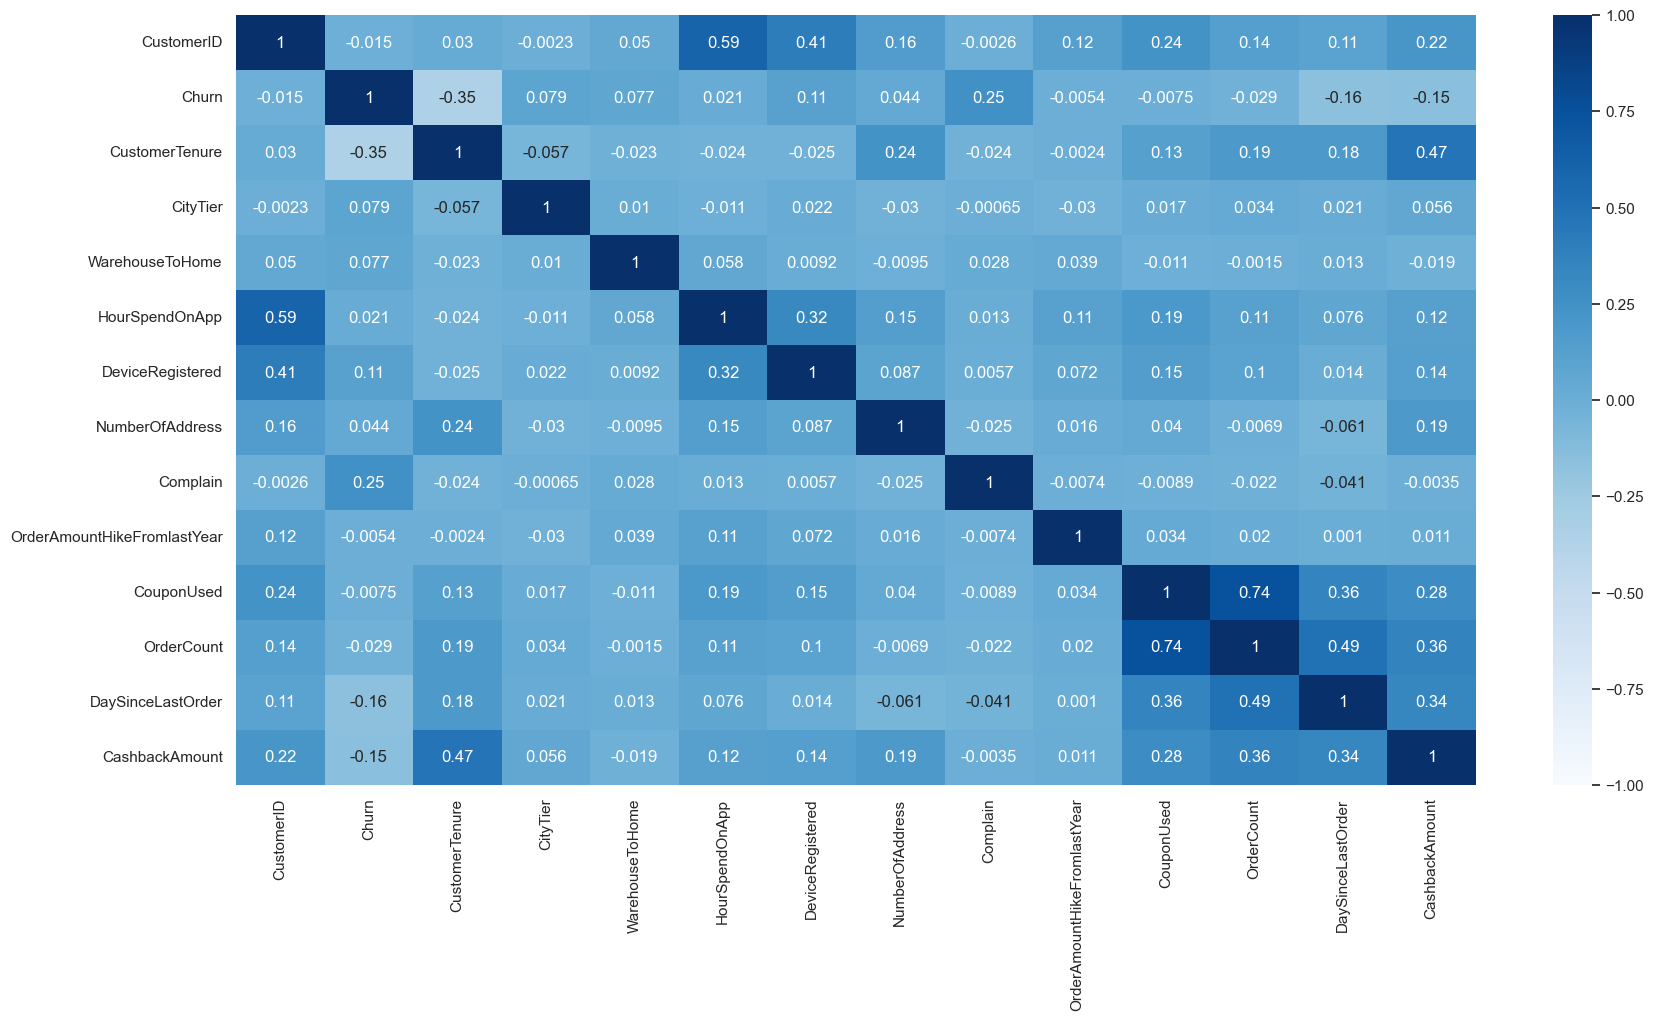

In [10]:
plt.figure(figsize=(20,10))
sns.heatmap(data.corr(), annot=True, vmin=-1, cmap='Blues')

In [14]:
#sns.pairplot(data)

Armar histogramas de frecuencia del churn vs cada variable

In [18]:
data_without_target = data.drop(['Churn'], axis=1)

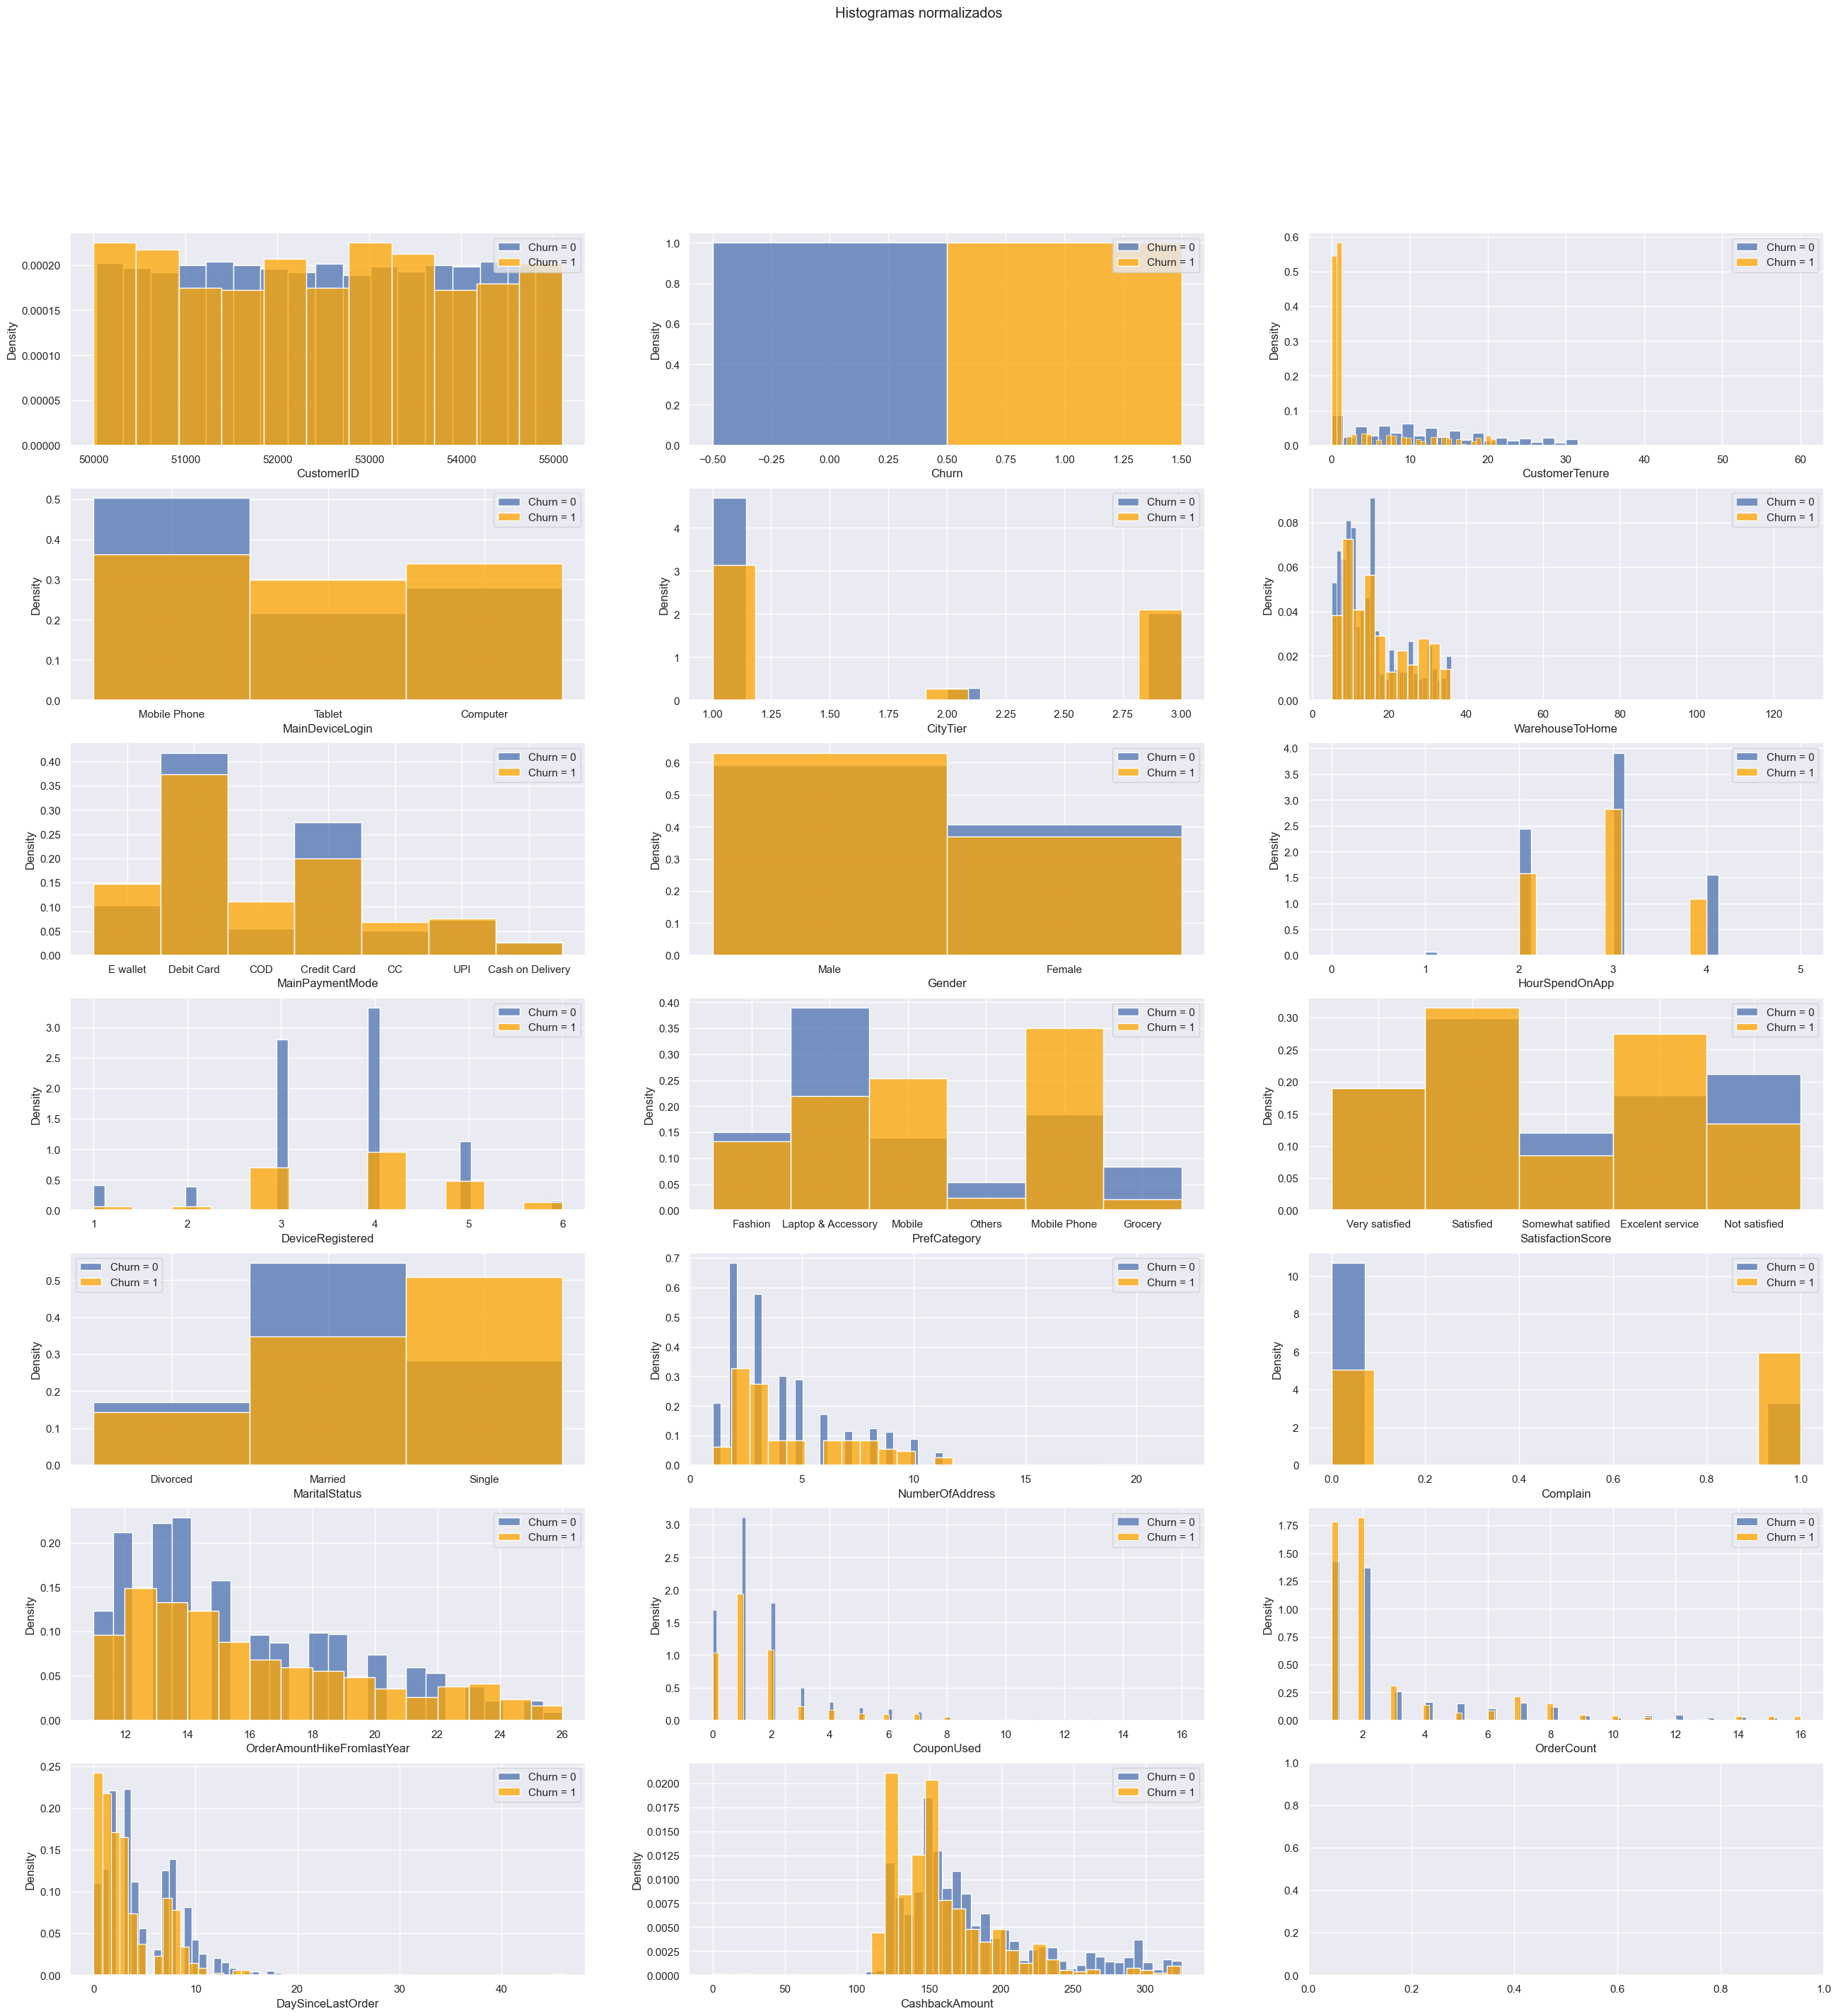

In [27]:
fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(32,32))
fig.suptitle('Histogramas normalizados')
for c, ax in zip(data.columns, axes.flatten()):
    sns.histplot(data = data.loc[data['Churn']==0, c].dropna(), stat = 'density', ax = ax, kde = False )
    sns.histplot(data = data.loc[data['Churn']==1, c].dropna(), stat = 'density', kde=False, ax=ax, color = 'orange')
    ax.legend(['Churn = 0', 'Churn = 1'])

## Limpieza de datos

In [16]:
data_clean = data.dropna()
data_clean.shape

(3366, 20)

## Preparación de datos

### Variables categóricas (dummies y ordinales)

### Variables numéricas (normalización?)

## Separación de datos

## En cada modelo ver los distintos indicadores y decidir cuál es el más apropiado para el dataset

## KNN

## Regresión logística

## Naive Bayes

## Conclusiones